THE SEMANTIC CHUNKING AND THE LANGUAGE-SPECIFIC EMBEDDINGS WITH METADATA:

In [ ]:
''' 
This script processes structured markdown medicine leaflets, performs section-based chunking with metadata then 
stores the resulting documents in a Chroma vectorstore with embeddings/ At the end it saves a list of known medication names
as .pkl file to use later in the medication identification function

'''


# Step 1: Configuration and Model Setup 
import os
import re
import html
from langchain.schema import Document
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma

MD_DIR = "data/extracted_docling.md"  # Path to the markdown leaflets
PERSIST_DIRECTORY = "data"            # Path for Chroma persistence
COLLECTION_NAME = "algerian_med_leaflets"

embedding_model = HuggingFaceEmbeddings(
    model_name="OrdalieTech/Solon-embeddings-base-0.1"
)

all_documents_with_metadata = []
known_medication_names = set()

def clean_header(header):
    header = html.unescape(header)
    header = re.sub(r"[^A-Za-zÀ-ÿ0-9\s]", "", header)
    header = re.sub(r"\s{2,}", " ", header)
    return header.strip().upper()

def extract_medication_identifier(filename):
    name_parts = os.path.splitext(filename)[0].split('_')
    relevant_parts = []
    for part in name_parts:
        if re.match(r'^B_\d+$', part):
            break
        relevant_parts.append(part)
    identifier = '_'.join(relevant_parts)
    cleaned = identifier.replace('_', ' ').strip().title()
    return cleaned if cleaned else filename

# Step 2: Markdown Processing and Chunking 
print(f"Reading leaflets from: {MD_DIR}")

for filename in os.listdir(MD_DIR):
    if not filename.endswith(".md"):
        continue
    filepath = os.path.join(MD_DIR, filename)
    medication_identifier = extract_medication_identifier(filename)
    known_medication_names.add(medication_identifier)

    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            content = f.read()

        sections = re.split(r"\n##\s*", content)
        if sections and not sections[0].strip():
            sections = sections[1:]

        if not sections:
            if content.strip():
                sections = [{"title": "DOCUMENT CONTENT", "content": content.strip()}]
            else:
                continue  # Skip empty file

        processed_sections = []
        if isinstance(sections[0], str):
            for i, section_text in enumerate(sections):
                lines = section_text.strip().split('\n', 1)
                section_title = clean_header(lines[0]) if lines and lines[0].strip() else f"SECTION {i+1}"
                content_body = lines[1].strip() if len(lines) > 1 else lines[0].strip()
                if not content_body:
                    continue  # Skip empty section
                processed_sections.append({"title": section_title, "content": content_body})
        else:
            processed_sections = sections

        #  Metadata Parsing and Attachment to each chunk
        for i, section in enumerate(processed_sections):
            metadata = {
                "medication_name": medication_identifier,
                "source_file": filename,
                "section": section["title"],
                "chunk_index": i
            }
            doc = Document(page_content=section["content"], metadata=metadata)
            all_documents_with_metadata.append(doc)

    except Exception as e:
        print(f"Error processing {filename}: {e}")

print(f"Created {len(all_documents_with_metadata)} chunks.")
print(f" Unique medications detected: {len(known_medication_names)}")

# Step 3: Embedding and Storage in Chroma Vectorstore
os.makedirs(PERSIST_DIRECTORY, exist_ok=True)
print(f"Storing collection '{COLLECTION_NAME}'...")

try:
    vectorstore = Chroma.from_documents(
        documents=all_documents_with_metadata,
        embedding=embedding_model,
        persist_directory=PERSIST_DIRECTORY,
        collection_name=COLLECTION_NAME
    )
    print("Vectorstore creation complete.")
except Exception as e:
    print(f"Error storing documents in Chroma: {e}")

# Step 4: Saving Known Medication List as a pkl file to use it later in the retrival 
import pickle

known_medication_list = sorted(list(known_medication_names))
with open("known_medications.pkl", "wb") as f:
   pickle.dump(known_medication_list, f)
   


In [ ]:
## Example of the metadata attached to the chunks 

from collections import defaultdict
import random
from pprint import pprint


# Grouping chunks by medication name
grouped_chunks = defaultdict(list)
for doc in all_documents_with_metadata:
    grouped_chunks[doc.metadata["medication_name"]].append(doc)

# Sampling one random chunk from 5 different meds
sampled_records = []
for med_name in list(grouped_chunks.keys())[:5]:  
    doc = random.choice(grouped_chunks[med_name])
    sampled_records.append({
        "chunk_index": doc.metadata["chunk_index"],
        "medication_name": doc.metadata["medication_name"],
        "section": doc.metadata["section"],
        "source_file": doc.metadata["source_file"]
    })

## The results 
print("Sample Metadata Records Across Medications:\n")
for record in sampled_records:
    pprint(record, sort_dicts=False, indent=4)
    print("-" * 60)



Sample Metadata Records Across Medications:

{   'chunk_index': 3,
    'medication_name': 'Abufene 400Mg Comp  B 30',
    'section': 'IDENTIFICATION DU MÉDICAMENT',
    'source_file': 'ABUFENE 400MG COMP_ B_30.md'}
------------------------------------------------------------
{   'chunk_index': 4,
    'medication_name': 'Acifudal 0 02 Creme Derm  T 15G',
    'section': 'FORME GEL',
    'source_file': 'ACIFUDAL 0_02 CREME DERM_ T_15G.md'}
------------------------------------------------------------
{   'chunk_index': 13,
    'medication_name': 'Actrapid Hm Penfill 100Ui Ml Sol Inj  B 5 Cart  De 1 5 '
                       'Ml Et B 5Cart  De 3Ml',
    'section': 'ACTRAPID CONTIENT DU SODIUM',
    'source_file': 'ACTRAPID HM PENFILL 100UI_ML SOL INJ_ B_5 CART_ de 1_5 ML '
                   'ET B_5CART  DE 3ML.md'}
------------------------------------------------------------
{   'chunk_index': 6,
    'medication_name': 'Adepal 0 15Mg 0 03Mg Blancs   Et 0 20Mg 0 04Mg Rose '
               

In [ ]:
"""
Enhanced RAG Pipeline Script (with Metadata Filtering)

This script performs medication-aware question answering using a Retrieval-Augmented Generation (RAG) approach. 
It loads test cases, detects the medication name mentioned in the query, filters the Chroma vector store by 
metadata (medication_name), and uses a strict French prompt with MistralAI to generate grounded answers.

The output is saved in RAGAS-compatible CSV format for evaluation.
"""

# Imports :
import pandas as pd
import pickle
import re
from langchain_community.llms import HuggingFaceHub 
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_mistralai.chat_models import ChatMistralAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import RetrievalQA

## Importing the test_cases that contain the questions which will be asked to the system :

from test_cases import test_cases




# Configuration 

embedding_model = HuggingFaceEmbeddings(model_name ="OrdalieTech/Solon-embeddings-base-0.1")
EMBEDDING_DEVICE = "cuda"  
PERSIST_DIRECTORY = "data"
COLLECTION_NAME = "algerian_med_leaflets"
k_chunks = 6
try:
    vector_store = Chroma(persist_directory=PERSIST_DIRECTORY, embedding_function=embedding_model, collection_name=COLLECTION_NAME)
    print(f"Connected to Chroma DB: {COLLECTION_NAME} in {PERSIST_DIRECTORY}")
except Exception as e:
    print(f"Error connecting to Chroma DB: {e}")
    vector_store = None

#  Initializing the Mistral AI model with optimal parameters 

llm = ChatMistralAI(
    mistral_api_key='PUT_YOUR_API_KEY_HERE', 
    model="mistral-small-latest",
    temperature=0.0,
    max_tokens=10000
)



RAG_prompt = ChatPromptTemplate.from_template("""
1. **IDENTIFIE le nom EXACT du médicament** mentionné dans le CONTEXTE fourni. N'utilise que CE nom.
2. **Réponds UNIQUEMENT** si la question porte sur le médicament IDENTIFIÉ dans le contexte ET si l'information demandée est présente dans le contexte.
3. **Interdictions formelles** : Aucune information non présente dans le contexte. Aucun autre nom de médicament.

### PROTOCOLE DE VÉRIFICATION (POUR VOTRE RAISONNEMENT INTERNE SEULEMENT - NE PAS AFFICHER CE PROTOCOLE DANS LA RÉPONSE)
1. Quel est le nom du médicament dans le CONTEXTE ?
2. La QUESTION porte-t-elle sur CE médicament ?
3. L'information demandée dans la QUESTION est-elle dans le CONTEXTE ?

### FORMAT DE RÉPONSE CONTRAINT
[VÉRIFICATION INITIALE]
"Après analyse complète de la notice officielle de [RÉPONSE UNIQUE: LE NOM EXACT DU MÉDICAMENT IDENTIFIÉ DANS LE CONTEXTE] fournie :"

[PRÉSENTATION DES PREUVRES]
"**Source textuelle directe** (extrait fidèle) :
« [Citation EXACTE du contexte pertinente pour la réponse] »"

[INTERPRÉTATION CADRÉE]
"Ceci signifie que : [Explication courte basée uniquement sur la citation]"

[LIMITES]
"Information disponible : [Oui/Non/Partielle]
Couverture contextuelle : [Complete/Partielle/Section X seulement]"

### RÉPONSE PAR DÉFAUT (SI LES CONDITIONS NE SONT PAS REMPLIES)
"Impossible de répondre :
- [Raison spécifique : médicament non trouvé dans le contexte / information absente dans le contexte]
- Consulter un pharmacien pour les questions hors notice"

### CONTEXTE FOURNI
{context}

### QUESTION
{question}
""")


# Loading the known_medication_list
try:
    with open('known_medications.pkl', 'rb') as f:
        known_medication_list = pickle.load(f)
except:
    known_medication_list = []

#  Medication Name Detection Logic :
   
   ## Set of common French stopwords to exclude from matching with the query :

FRENCH_STOPWORDS = set([
    "un", "une", "des", "le", "la", "les", "de", "du", "des", "ce", "cet", "cette", "ces",
    "mon", "ton", "son", "ma", "ta", "sa", "mes", "tes", "ses", "notre", "votre", "leur",
    "nos", "vos", "leurs", "je", "tu", "il", "elle", "on", "nous", "vous", "ils", "elles",
    "j'", "t'", "l'", "s'", "m'", "c'",
    "au", "aux", "quel", "quelle", "quelles", "quels", "qui", "que", "quoi", "dont", "où",
    "pour", "par", "sur", "sous", "avec", "sans", "dans", "en", "vers", "chez",
    "a", "as", "avons", "avez", "ont", "ai",
    "suis", "es", "est", "sommes", "êtes", "sont", "serai", "seras", "sera", "serons", "serez", "seront",
    "étais", "était", "étions", "étiez", "étaient",
    "peut", "peux", "peuvent", "pourrait", "pourrais", "pourrions", "pourriez", "pourraient", "peut-il", "est-ce",
    "être", "avoir", "faire", "dire", "pouvoir", "vouloir", "savoir", "voir", "devoir", "falloir",
    "utiliser", "utilisé", "comment", "si", "j","c","l"
])

  ## Regex patterns to eliminate irrelevant codes (e.g., batch numbers like B_123)

PATTERNS_TO_ELIMINATE = [
    r'\b(b|fl|p)\s*\d+\b' 
]


def normalize_forms_abbreviations(text):
    """
    Replaces pharmaceutical form words with normalized abbreviations 
    (e.g., 'comprimé' → 'comp', 'gélule' → 'gel').
    Assumes input is lowercased.
    """ 
    text = re.sub(r'\bcomprimés\b', 'comp', text, flags=re.IGNORECASE)
    text = re.sub(r'\bcomprimé\b', 'comp', text, flags=re.IGNORECASE)
    text = re.sub(r'\bsachets-dose\b', 'sachet', text, flags=re.IGNORECASE)
    text = re.sub(r'\bsachet-dose\b', 'sachet', text, flags=re.IGNORECASE)
    text = re.sub(r'\bsachets\b', 'sachet', text, flags=re.IGNORECASE)
    text = re.sub(r'\bsuppositoire\b', 'suppo', text, flags=re.IGNORECASE)
    text = re.sub(r'\bsuspension\b', 'susp', text, flags=re.IGNORECASE)
    text = re.sub(r'\bsolution\b', 'sol', text, flags=re.IGNORECASE)
    text = re.sub(r'\bpoudre\b', 'pdre', text, flags=re.IGNORECASE)
    text = re.sub(r'\bgélule(s)?\b', 'gel', text, flags=re.IGNORECASE)
    text = re.sub(r'\bgouttes\b', 'gttes', text, flags=re.IGNORECASE)
    
    return text


def normalize_dosage_tokens_final(text): 
    """
    Standardizes dosage expressions into consistent format (e.g., '500 mg' → '500mg').
    Assumes input is lowercased.
    """
    text = re.sub(r'(\d+)\s+(000)\s*(ui|kui|mui|mg|ml|g)\b', r'\1\2\3', text)
    text = re.sub(r'(\d+)\s+(000)(ui|kui|mui|mg|ml|g)\b', r'\1\2\3', text)
    text = re.sub(r'(\d+)\s+(\d+)(mg|ml|g|ui|kui|mui)\b', r'\1\2\3', text)
    patterns_replacements = [
        (r'(\d+(?:[.,]\d+)?)\s*(mg)(?!\w)', r'\1mg'), (r'(\d+)\s*(mg)(?!\w)', r'\1mg'),
        (r'(\d+(?:[.,]\d+)?)\s*(ml)(?!\w)', r'\1ml'), (r'(\d+)\s*(ml)(?!\w)', r'\1ml'),
        (r'(\d+(?:[.,]\d+)?)\s*(g)(?!\w)',  r'\1g'),  (r'(\d+)\s*(g)(?!\w)',  r'\1g'),
        (r'(\d+(?:[.,]\d+)?)\s*(ui)(?!\w)', r'\1ui'), (r'(\d+)\s*(ui)(?!\w)', r'\1ui'),
        (r'(\d+(?:[.,]\d+)?)\s*(kui)(?!\w)',r'\1kui'),(r'(\d+)\s*(kui)(?!\w)',r'\1kui'),
        (r'(\d+(?:[.,]\d+)?)\s*(mui)(?!\w)',r'\1mui'),(r'(\d+)\s*(mui)(?!\w)',r'\1mui')
    ]
    for pattern, replacement in patterns_replacements:
        text = re.sub(pattern, replacement, text)
    return text

def preprocess_text_for_matching(text, patterns_to_eliminate_list, stopwords_list, dosage_normalization_func, form_normalization_func):
    """
    Applies full text normalization for medication matching:
    - Lowercasing
    - Form and dosage standardization
    - Stopword removal
    - Token filtering
     Returns a set of meaningful words.
    """
    processed_text = str(text).lower()
    processed_text = form_normalization_func(processed_text)
    for pattern in patterns_to_eliminate_list:
        processed_text = re.sub(pattern, '', processed_text, flags=re.IGNORECASE)
    processed_text = dosage_normalization_func(processed_text)
    words = re.findall(r'[\w\-.]+(?:(?:[\.,]\d+)?\w*)?', processed_text)
    meaningful_words = []
    for word in words:
        word_stripped = word.strip("., ")
        if not word_stripped or word_stripped in stopwords_list:
            continue
        meaningful_words.append(word_stripped)
    return set(meaningful_words)

# Medication Name identification function :

def identify_medication_in_query(query, known_medications_list, min_overlap_count=2):
    """
    Identifies the best-matching medication name from a known list based on word overlap.
    
    - Uses normalized matching with stopword and noise filtering.
    - Requires at least `min_overlap_count` shared words between the query and the medication name.
    
    Returns the best matching medication name (string) or None.
    """
    query_words = preprocess_text_for_matching(query, PATTERNS_TO_ELIMINATE, FRENCH_STOPWORDS, normalize_dosage_tokens_final, normalize_forms_abbreviations)
    best_match = None
    max_matching_words = 0
    if not isinstance(known_medications_list, list) or not known_medications_list:
        print("Warning: known_medications_list is empty or not a list.")
        return None
    sorted_known_meds = sorted(known_medications_list, key=len, reverse=True)

    for med_name_original in sorted_known_meds:
        med_words = preprocess_text_for_matching(med_name_original, PATTERNS_TO_ELIMINATE, FRENCH_STOPWORDS, normalize_dosage_tokens_final, normalize_forms_abbreviations)
        if not med_words:
            continue
        matching_words = med_words.intersection(query_words)
        num_matching_words = len(matching_words)

        if num_matching_words >= min_overlap_count:
            if num_matching_words > max_matching_words:
                max_matching_words = num_matching_words
                best_match = med_name_original
            elif num_matching_words == max_matching_words:
                if best_match is None or len(med_name_original) > len(best_match):
                    best_match = med_name_original
    
    if best_match:
        final_best_match_processed_words = preprocess_text_for_matching(best_match, PATTERNS_TO_ELIMINATE, FRENCH_STOPWORDS, normalize_dosage_tokens_final, normalize_forms_abbreviations)
        final_matching_num = len(final_best_match_processed_words.intersection(query_words))
        if final_matching_num < min_overlap_count:
            best_match = None 
    return best_match

# Initializing RAGAS input list
ragas_evaluation_data = []

# Verifying if test cases exist to start the loop :

if not ('test_cases' in locals() or 'test_cases' in globals()) or not test_cases:
    print("ERROR: 'test_cases' not defined or empty.")
else:
    print(f"Starting RAG pipeline on {len(test_cases)} test cases...")

    for test_case in test_cases:
        qid = test_case["question_id"]
        query = test_case["question"]
        ground_truth = test_case["ground_truth"]

        print(f" Processing Test Case: {qid}")
        identified_med_name = identify_medication_in_query(query, known_medication_list) if known_medication_list else None
        retrieval_filter = {"medication_name": identified_med_name} if identified_med_name else None

        if vector_store:
            try:
                search_kwargs = {"k": k_chunks}
                if retrieval_filter:
                    search_kwargs["filter"] = retrieval_filter
                retriever = vector_store.as_retriever(search_kwargs=search_kwargs)
            except Exception as e:
                ragas_evaluation_data.append({
                    "question_id": qid, "question": query,
                    "answer": f"ERROR: Retriever config failed - {e}", "contexts": [], "ground_truth": ground_truth
                })
                continue
        else:
            ragas_evaluation_data.append({
                "question_id": qid, "question": query,
                "answer": "ERROR: Vector store not available", "contexts": [], "ground_truth": ground_truth
            })
            continue

        try:
            qa_chain = RetrievalQA.from_chain_type(
                llm=llm,
                retriever=retriever,
                return_source_documents=True,
                chain_type="stuff",
                chain_type_kwargs={"prompt": RAG_prompt}
            )
        except Exception as e:
            ragas_evaluation_data.append({
                "question_id": qid, "question": query,
                "answer": f"ERROR: QA chain setup failed - {e}", "contexts": [], "ground_truth": ground_truth
            })
            continue

        try:
            response = qa_chain.invoke({"query": query})
            answer = response.get("result", "No answer generated.")
            contexts = [doc.page_content for doc in response.get("source_documents", [])]
        except Exception as e:
            answer = f"ERROR: Chain execution failed - {e}"
            contexts = []

        ragas_evaluation_data.append({
            "question_id": qid, "question": query,
            "answer": answer, "contexts": contexts, "ground_truth": ground_truth
        })

# Save to CSV
if ragas_evaluation_data:
    try:
        df = pd.DataFrame(ragas_evaluation_data)
        df.to_csv("ragas_input_data_final.csv", index=False, encoding='utf-8-sig')
        print("Results saved to ragas_input_data_final.csv")
    except Exception as e:
        print(f" Error saving CSV: {e}")
else:
    print("No data collected for RAGAS.")


In [ ]:
"""
Extracts the '[INTERPRÉTATION CADRÉE]' block from an LLM response.

Removes quotes and the prefix 'Ceci signifie que :' to return the clean interpretation.
Returns an empty string if the block is missing or improperly formatted.
"""

def extract_exact_interpretation_content(full_llm_response_text):
    text_content = str(full_llm_response_text).replace('\\n', '\n')
    interpretation_marker = "[INTERPRÉTATION CADRÉE]\n"
    interpretation_content = ""

    if interpretation_marker in text_content:
        try:
            block_content_full = text_content.split(interpretation_marker, 1)[1].strip()
            block_content_unquoted = block_content_full
            if block_content_full.startswith('"') and block_content_full.endswith('"'):
                block_content_unquoted = block_content_full[1:-1].strip()
            prefix_to_remove_pattern = r'Ceci signifie que\s*:\s*'
            if re.match(prefix_to_remove_pattern, block_content_unquoted, re.IGNORECASE):
                actual_interpretation = re.sub(prefix_to_remove_pattern, '', block_content_unquoted, count=1, flags=re.IGNORECASE).strip()
            else:
                actual_interpretation = block_content_unquoted.strip()
            if actual_interpretation:
                interpretation_content = actual_interpretation
        except IndexError:
            pass

    if text_content.strip().startswith("ERROR:"):
        return text_content.strip()

    return interpretation_content.strip()


In [ ]:
'''
   This script post-processes the generated RAG answers:
 - Loads raw results from 'ragas_input_data_final.csv'
 - Cleans the 'answer' column to isolate the [INTERPRÉTATION CADRÉE] block
 - Saves a filtered version of the dataset for RAGAS evaluation in the file :"ragas_dataset_enhanced_RAG.csv"

'''


input_csv_filename = "ragas_input_data_final.csv"
output_csv_filename = "ragas_dataset_enhanced_RAG.csv"

try:
    df = pd.read_csv(input_csv_filename)
    if 'answer' not in df.columns:
        raise ValueError("CSV file must contain an 'answer' column.")

    df['answer'] = df['answer'].apply(extract_exact_interpretation_content)
    required_cols = ['question_id', 'question', 'answer', 'contexts', 'ground_truth']
    df[required_cols].to_csv(output_csv_filename, index=False, encoding='utf-8-sig')

except FileNotFoundError:
    print(f"CRITICAL ERROR: Input CSV file '{input_csv_filename}' not found.")
except ValueError as ve:
    print(f"ValueError: {ve}")
except Exception as e:
    print(f"Unexpected error during post-processing: {e}")
    


THE RAGAS EVALUATION PROCESS FOR THE ENHANCED RAG :


In [ ]:
# Dataset and parsing utilities
from datasets import Dataset
import ast  
   

# RAGAS Evaluation Metrics
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness,
    answer_similarity
)

# Langchain components
from langchain_mistralai.chat_models import ChatMistralAI
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_openai import ChatOpenAI 


In [ ]:
csv_filename = "ragas_dataset_enhanced_RAG.csv"

try:
    df = pd.read_csv(csv_filename)
except FileNotFoundError:
    print(f"ERROR: File '{csv_filename}' not found.")
    exit()
except Exception as e:
    print(f"Error loading CSV: {e}")
    exit()

try:
    df['contexts'] = df['contexts'].fillna('[]').astype(str)
    if isinstance(df['contexts'].iloc[0], str):
        df['contexts'] = df['contexts'].apply(ast.literal_eval)
except Exception as e:
    print(f"Error converting 'contexts' column: {e}")
    exit()

required_cols = ['question', 'answer', 'contexts', 'ground_truth']
cols_for_hf_dataset = ['question_id'] + required_cols if 'question_id' in df.columns else required_cols

if any(col not in df.columns for col in required_cols):
    print("ERROR: Missing required RAGAS columns.")
    exit()

try:
    ragas_hf_dataset = Dataset.from_pandas(df[cols_for_hf_dataset])
except Exception as e:
    print(f"Error converting to Hugging Face Dataset: {e}")
    exit()


In [ ]:
"""
The code below loads the enhanced RAG output CSV, formats the context column,
verifies required fields, and converts the data into a Hugging Face Dataset
for RAGAS evaluation.
"""


import os
from langchain_openai import ChatOpenAI
from langchain_community.embeddings import HuggingFaceEmbeddings

try:
    evaluator_llm = ChatOpenAI(
        openai_api_key="PUT_YOUR_OPENAI_API_KEY_HERE",
        model_name="gpt-4o",
        temperature=0.4,
        max_tokens=2000
    )
except Exception as e:
    print(f"Error configuring ChatOpenAI: {e}")
    evaluator_llm = None

try:
    ragas_embedding_model = HuggingFaceEmbeddings(
        model_name="OrdalieTech/Solon-embeddings-base-0.1"
    )
except Exception as e:
    print(f"Error converting DataFrame to Hugging Face Dataset: {e}")
    ragas_embedding_model = None


In [ ]:
import time

metrics_to_evaluate = [
    faithfulness,
    answer_relevancy,
    context_precision,
    context_recall,
    answer_correctness,
    answer_similarity
]

## Running RAGAS metric evaluation on the enhanced RAG dataset with retry logic and delays:

def safe_ragas_eval(dataset, metrics, llm, embeddings, batch_size=1, delay=10, max_retries=4):

    results = []
    failed = []

    for idx in range(len(dataset)):
        sample = dataset.select([idx])
        retries = 0

        while retries <= max_retries:
            try:
                result = evaluate(
                    dataset=sample,
                    metrics=metrics,
                    llm=llm,
                    embeddings=embeddings,
                )
                scores = result.to_pandas().iloc[0].to_dict()
                scores["question_id"] = sample["question_id"][0] if "question_id" in sample.column_names else idx
                results.append(scores)
                time.sleep(5)
                break
            except Exception:
                retries += 1
                time.sleep(delay * (2 ** retries))

        if retries > max_retries:
            failed.append(idx)

    return pd.DataFrame(results), failed

final_scores_df, failed_indices = safe_ragas_eval(
    dataset=ragas_hf_dataset,
    metrics=metrics_to_evaluate,
    llm=evaluator_llm,
    embeddings=ragas_embedding_model,
    batch_size=1,
    delay=10,
    max_retries=4,
)

## Saving the evaluation results to a csv file 
final_scores_df.to_csv("ragas_results.csv", index=False)

if failed_indices:
    print(f"Failed evaluations: {failed_indices}")


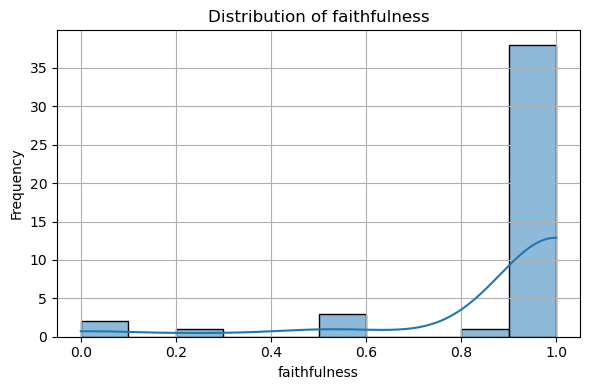

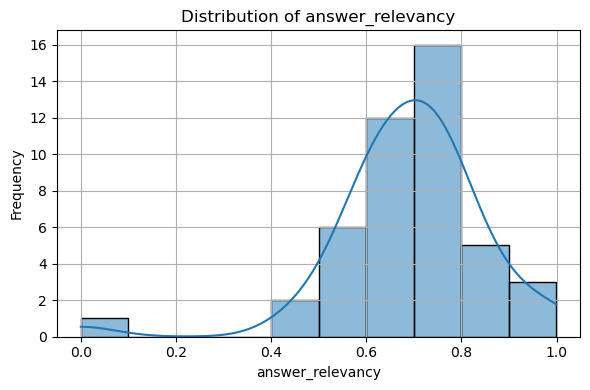

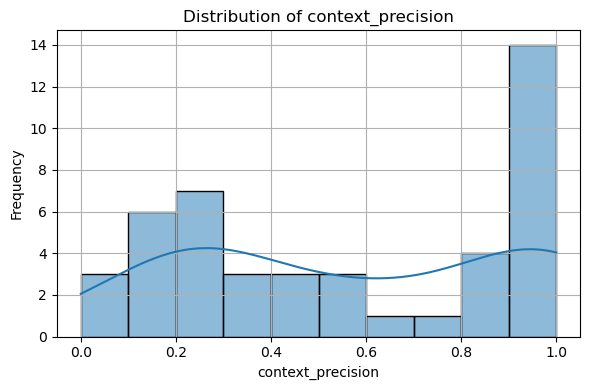

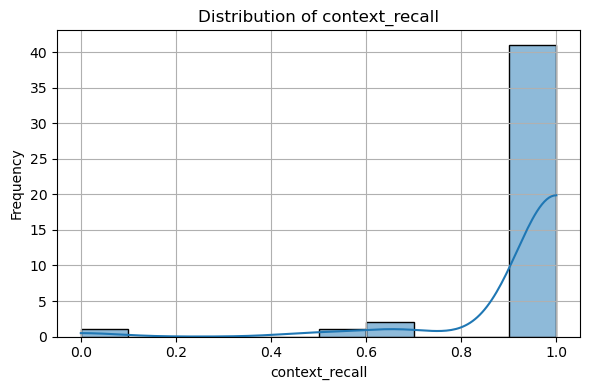

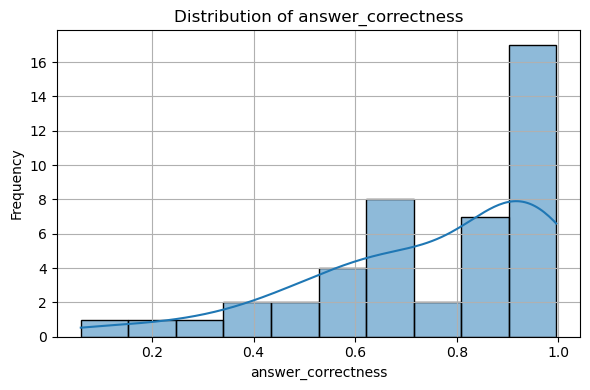

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

## ploting the distribution histograms for each RAGAS evaluation metric of the enhanced RAG system
metrics = ['faithfulness', 'answer_relevancy', 'context_precision', 'context_recall', 'answer_correctness']

for metric in metrics:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[metric], bins=10, kde=True)
    plt.title(f'Distribution of {metric}')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
"""
This code is to inspect and analyze the evaluation results. It prints 10 sample outputs, and computes average scores per metric.

"""
csv_filename = "ragas_results.csv" 
try:
    scores_df = pd.read_csv(csv_filename)
    print(f"Successfully loaded RAGAS scores from '{csv_filename}'")
    print(f"Number of evaluated questions: {len(scores_df)}")

    print("\n--- DataFrame Info ---")
    scores_df.info()

    print("\n--- RAGAS Scores (First 10 Rows) ---")
   
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.max_rows', 20) 
    print(scores_df.head(10).to_string())

    print("\n--- Aggregated RAGAS Scores (Averages) ---")
    metric_columns = [
        'faithfulness', 
        'answer_relevancy', 
        'context_precision', 
        'context_recall', 
        'answer_correctness',
        'semantic_similarity' 
    ]
    
    for metric_name in metric_columns:
        if metric_name in scores_df.columns:
         
            scores_df[metric_name] = pd.to_numeric(scores_df[metric_name], errors='coerce')
          
            mean_score = scores_df[metric_name].mean(skipna=True)
            if pd.notna(mean_score):
                print(f"Average {metric_name}: {mean_score:.4f}")
            else:
                print(f"Average {metric_name}: Not available (all values might be NaN or non-numeric after coercion).")
        else:
            print(f"Metric column '{metric_name}' not found in results DataFrame.")

except FileNotFoundError:
    print(f"ERROR: File '{csv_filename}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully loaded RAGAS scores from 'ragas_results.csv'
Number of evaluated questions: 45

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_input           45 non-null     object 
 1   retrieved_contexts   45 non-null     object 
 2   response             45 non-null     object 
 3   reference            45 non-null     object 
 4   faithfulness         45 non-null     float64
 5   answer_relevancy     45 non-null     float64
 6   context_precision    45 non-null     float64
 7   context_recall       45 non-null     float64
 8   answer_correctness   45 non-null     float64
 9   semantic_similarity  45 non-null     float64
 10  question_id          45 non-null     object 
dtypes: float64(6), object(5)
memory usage: 4.0+ KB

--- RAGAS Scores (First 10 Rows) ---
                                         

 ENHANCED RAG QUALITATIVE ANALYSIS 


This section presents the Enhanced RAG System’s responses to the two questions previously used to evaluate the Naive system, where it had failed. The goal is to qualitatively demonstrate the improvements brought by the applied enhancements — namely section-based chunking, French-language embeddings, and metadata-aware retrieval — when applied to Algerian Patient Information Leaflets (PILs).

The outputs are extracted from the RAGAS results file but they only include what is needed for the qualitative analysis :
- The system’s generated answer
- The top retrieved chunks used as context



In [ ]:
'''
This script extracts two evaluation questions (Q15 and Q38) from 'ragas_results.csv'.
For each, it displays:
- The user query
- The Enhanced system's generated answer
- The retrieved context chunks (first 300 characters each)

These outputs will be compared with the previously seen answers from the Naive system.
'''


df = pd.read_csv('ragas_results.csv')

# Converting the 'contexts' column from string to list
df['contexts'] = df['retrieved_contexts'].apply(ast.literal_eval)

# Filterimg for the desired questions
filtered_df = df[df['question_id'].isin(['Q15', 'Q38'])]

# Displaying the results
for idx, row in filtered_df.iterrows():
    print(f"Question ID: {row['question_id']}")
    print(f"Question: {row['user_input']}\n")
    print(f"Generated Answer:\n{row['response']}\n")
    print("Retrieved Chunks:")
    for i, context in enumerate(row['retrieved_contexts']):
        print(f"  Chunk {i+1}: {context[:300]}{'...' if len(context) > 300 else ''}\n")
    print("="*80)


Question ID: Q15
Question: Quels sont les cas à ne pas utiliser DEXOREN 0.25mg comp 

Generated Answer:
DEXOREN ne doit pas être utilisé en cas de certaines anomalies du fonctionnement cardiaque, ni en association avec le sultopride ou des injections intraveineuses de calcium.

Retrieved Chunks:
  Chunk 1: DEXOREN ® 0,25 mg

: comprimé sécable ; boîte de 20

  Chunk 2: Mode d'emploi et posologie du médicament DEXOREN ®

  Chunk 3: p cp

Digoxine

0,25 mg

  Chunk 4: Ce médicament ne doit pas être utilisé dans les cas suivants :

-  certaines anomalies du fonctionnement cardiaque,
-  en association avec le sultopride ou des injections intraveineuses de calcium.
-  Il faut se référer à la notice de l'emballage pour tout effet notoire d'un des excipients du méd...

  Chunk 5: Il n'a pas été mis en évidence de problème particulier lors de l'utilisation de ce médicament chez la femme enceinte. Toutefois, au cours des 3 derniers mois de la grossesse, il peut être nécessaire d'adapter la p